In [18]:
from __future__ import print_function
import os
import torchvision.models as models
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib
import time
import copy
import cv2
from PIL import Image

%matplotlib inline

In [2]:
def show_images(loader):
    d = iter(loader)
    images, labels = d.next()
    grid = torchvision.utils.make_grid(images)
    npimg = grid.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    print(labels)
    plt.imshow(npimg)
    plt.show()
    
def show_image_batch(images):
    grid = torchvision.utils.make_grid(images)
    npimg = grid.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    plt.imshow(npimg)
    plt.show()

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            


In [4]:
num_classes = 2
num_epochs = 1
feature_extract = True

In [6]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.mobilenet_v2(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

In [7]:
traindir = os.path.join(os.getcwd(), 'train')
testdir = os.path.join(os.getcwd(), 'test')

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transform),
    shuffle=True,
    batch_size=16,
    num_workers=2)
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transform),
    batch_size=16,
    num_workers=2)

data_transforms = {
    'train': transform,
    'val': transform
}

dataloaders_dict = {
    'train': train_loader,
    'val': test_loader
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Done Initializing Datasets and Dataloaders...")


Done Initializing Datasets and Dataloaders...


tensor([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0])


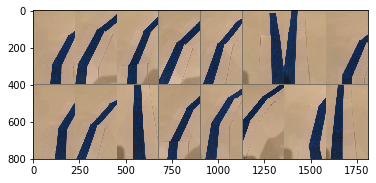

In [8]:
show_images(train_loader)

In [9]:
# Send the model to GPU/CPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(params_to_update)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [10]:
# Setup the loss fxn
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1541 Acc: 0.9622
val Loss: 0.0664 Acc: 0.9971

Epoch 1/24
----------
train Loss: 0.0682 Acc: 0.9776
val Loss: 0.0381 Acc: 0.9957

Epoch 2/24
----------
train Loss: 0.0338 Acc: 0.9909
val Loss: 0.0607 Acc: 0.9841

Epoch 3/24
----------
train Loss: 0.0251 Acc: 0.9972
val Loss: 0.0228 Acc: 0.9986

Epoch 4/24
----------
train Loss: 0.0323 Acc: 0.9916
val Loss: 0.0457 Acc: 0.9870

Epoch 5/24
----------
train Loss: 0.0168 Acc: 0.9958
val Loss: 0.0142 Acc: 0.9986

Epoch 6/24
----------
train Loss: 0.0294 Acc: 0.9902
val Loss: 0.0178 Acc: 0.9928

Epoch 7/24
----------
train Loss: 0.0431 Acc: 0.9867
val Loss: 0.0120 Acc: 0.9957

Epoch 8/24
----------
train Loss: 0.0201 Acc: 0.9937
val Loss: 0.0101 Acc: 0.9986

Epoch 9/24
----------
train Loss: 0.0197 Acc: 0.9930
val Loss: 0.0154 Acc: 0.9928

Epoch 10/24
----------
train Loss: 0.0186 Acc: 0.9944
val Loss: 0.0060 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0302 Acc: 0.9888
val Loss: 0.0068 Acc: 1.0000

Ep

In [13]:
torch.save(model_ft, './model_blue_20191104-12-02.pt')

In [11]:
torch.save({'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict()
            }, './state_dict_blue_20191104-12-02')

tensor([[[1.2899, 1.2728, 1.2899,  ..., 1.4269, 1.4269, 1.4098],
         [1.2899, 1.2728, 1.2728,  ..., 1.4269, 1.4269, 1.4269],
         [1.2899, 1.2728, 1.2728,  ..., 1.4098, 1.4269, 1.4440],
         ...,
         [1.4954, 1.4783, 1.4440,  ..., 1.4440, 1.4440, 1.4098],
         [1.4954, 1.4783, 1.4612,  ..., 1.4440, 1.4440, 1.4269],
         [1.5125, 1.4783, 1.4269,  ..., 1.4440, 1.4440, 1.4440]],

        [[0.9405, 0.9230, 0.9405,  ..., 1.0805, 1.0805, 1.0630],
         [0.9405, 0.9230, 0.9230,  ..., 1.0805, 1.0805, 1.0805],
         [0.9405, 0.9230, 0.9230,  ..., 1.0630, 1.0805, 1.0980],
         ...,
         [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
         [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
         [1.1506, 1.1331, 1.1155,  ..., 1.0805, 1.0805, 1.0805]],

        [[0.5136, 0.4962, 0.5136,  ..., 0.6008, 0.6182, 0.6008],
         [0.5136, 0.4962, 0.4962,  ..., 0.6182, 0.6182, 0.6182],
         [0.5136, 0.4962, 0.4962,  ..., 0.6008, 0.6182, 0.

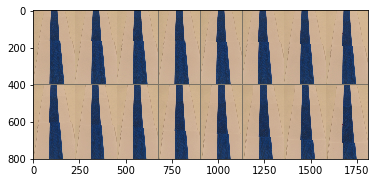

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [29]:
labels = {0: 'straight', 1: 'right'}
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        print(images[0])
        outputs = model_ft(images)
        show_image_batch(images)
        _, predicted = torch.max(outputs.data, 1)
#         print(labels[predicted.item()])
        print(predicted)
        break;

tensor([[[[1.2899, 1.2728, 1.2899,  ..., 1.4269, 1.4269, 1.4098],
          [1.2899, 1.2728, 1.2728,  ..., 1.4269, 1.4269, 1.4269],
          [1.2899, 1.2728, 1.2728,  ..., 1.4098, 1.4269, 1.4440],
          ...,
          [1.4954, 1.4783, 1.4440,  ..., 1.4440, 1.4440, 1.4098],
          [1.4954, 1.4783, 1.4612,  ..., 1.4440, 1.4440, 1.4269],
          [1.5125, 1.4783, 1.4269,  ..., 1.4440, 1.4440, 1.4440]],

         [[0.9405, 0.9230, 0.9405,  ..., 1.0805, 1.0805, 1.0630],
          [0.9405, 0.9230, 0.9230,  ..., 1.0805, 1.0805, 1.0805],
          [0.9405, 0.9230, 0.9230,  ..., 1.0630, 1.0805, 1.0980],
          ...,
          [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
          [1.1331, 1.1331, 1.1331,  ..., 1.0805, 1.0805, 1.0630],
          [1.1506, 1.1331, 1.1155,  ..., 1.0805, 1.0805, 1.0805]],

         [[0.5136, 0.4962, 0.5136,  ..., 0.6008, 0.6182, 0.6008],
          [0.5136, 0.4962, 0.4962,  ..., 0.6182, 0.6182, 0.6182],
          [0.5136, 0.4962, 0.4962,  ..., 0

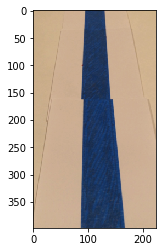

tensor([[ 3.5926, -3.2478]])


In [35]:
with torch.no_grad():
    model_ft.eval()
    img = cv2.imread('/Users/bryantpham/Documents/fa19/ML/FinalProject/testimgs/test-blue-straight-1-000001.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    t = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img = t(img).float()
    img = img.unsqueeze(0)
    img = torch.autograd.Variable(img)
    print(img)
    show_image_batch(img)

    outputs = model_ft(img)
    _, predicted = torch.max(outputs.data, 1)
    print(outputs)